In [ ]:
# test preprocessing
# 1. show video
# 2. frames and faces extraction from video
# 3. separate occ and no_occ frames
# 4. show occ and no_occ examples
# ----------------------------------------------- #

# clone repo from github



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import os
import timm # for using the XceptionNet model (pretrained) # pip install timm
import yaml
import glob
import matplotlib.pyplot as plt
from scipy.special import expit
import glob

from notebook_demo.demo_utils import *
from preprocessing.fows.frame_and_faces_extraction import *

In [ ]:
# add .. to syspath to access the rest of the repo
import sys
sys.path.append('..')

In [ ]:
%ls

In [ ]:

#@title Real and Fake videos pre-processing

# all user faces and preprocessing will be saved inside the demo folder
# just to show how the code works

# -------------------------------------------------------------- #

print("\nREAL_VIDEOS")
# NOTE: update path to demo video and user_faces
# check also other paths to files in the demo
real_vid = './demo_videos/real/'
real_faces = './user_faces/real/'
if not os.path.exists(real_faces):
  print("path doesn't exists")
  create_subfolders_demo(real_faces)
else:
  print("subfolders already exist")
  extract_subfolders(real_faces)

# breakpoint()

extract_faces_from_videos(extract_files(real_vid), extract_subfolders(real_faces))
print("\nsanity check: ")
# add sanity check to see if the number of frames extracted from the original videos is correct (390 frames)
for sub in extract_subfolders(real_faces):
    print("sub:", sub)
    print(len(extract_files(sub)))
    if len(extract_files(sub)) != 390: # check if all frames extracte from the video
        print("ERROR: number of frames extracted from the facedancer videos is not correct")
    else:
        print("number of frames extracted from the facedancer videos is correct")


# -------------------------------------------------------------- #




In [ ]:
# Organize Occ and No-Occ faces
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FOWS_demo/user_faces/' #'user_faces/'
preprocessed_path = '/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/' #'preprocessed_faces/'
organize_frames(dataset_path, preprocessed_path)
check_num_frames(preprocessed_path)

In [6]:
#@title Select the model:
baseline_model = 'xception' #@param ["mnetv2", "effnetb4", "xception"]
trn_strategy = 'FT' #@param ["FT", "TL"]
dataset = 'thesis' #@param ["thesis", "gotcha"]
frames_type = 'occ' #@param ["occ", "no_occ"]
dataset = dataset + '_' + frames_type

model_str = f'{baseline_model}_{dataset}_{trn_strategy}'

print(model_str)

xception_thesis_occ_FT


In [ ]:
# load the model 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, _ = load_model_from_path(baseline_model, trn_strategy, dataset, '../model_weights/')
model.to(device)
print("model loaded!")

In [7]:
# model = mobilenet_v2(pretrained=True)
model = models.mobilenet_v2(weights = 'MobileNet_V2_Weights.IMAGENET1K_V2')

# Replace the classifier layer
model.classifier[1] = nn.Linear(model.last_channel, 1) # only 1 output -> prob of real of swap face

In [ ]:
# pretrained_model_path = '/media/data/model_exp_results/face_occ_net/results_FT/MobileNetV2_thesis_occ_FT/training/MobileNetV2_FT_2024-10-17-15-33-53/best_checkpoint.pth'  #args.save_model_path                 
# best_ckpt = torch.load(pretrained_model_path, map_location = "cpu")
# model.load_state_dict(best_ckpt['model'])

<All keys matched successfully>

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

In [ ]:
dataset

'fows_occ'

In [ ]:
# Define the paths to the preprocessed real and fake faces
real_faces_dir = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/{vid}/real/{frames_type}/'
fake_faces_dir = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/{vid}/fake/{frames_type}/'

# real_faces_dir_no_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/real/{dataset}/no_occ/'
# fake_faces_dir_no_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/fake/{dataset}/no_occ/'

In [ ]:
fake_faces_dir

'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/hand_occlusion/fake/occ/'

In [ ]:
import glob

print(glob.glob(real_faces_dir+'/*')[0])

/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/hand_occlusion/real/occ/frame200.jpg


In [ ]:
# import os
# import sys
# import argparse
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# # import torch.models as models
# from torchvision import models
# import timm  # for xception model
# # from torchvision import models

# # from utils.focalLoss import FocalLoss
# # from utils.customDataset import FaceImagesDataset
# # from utils.logger import create_logger
# # from utils.train_val_test import *
# # from utils.get_pretrained_model import get_pretrained_path

# def vm_get_model_pat(model_weights_path, model_str):
#     # model_weights_path = '/media/data/model_exp_results/face_occ_net/results_FT/' # '/TL/'
#     # model_str = 'mnetv2_gotcha_no_occ_FT'
#     # MnetV2_gotcha_no_occ_FT

#     model_path = ''
#     for root, dirs, files in os.walk(model_weights_path):
#         if model_str.lower() in root.lower(): #print("found: ", root)
#         # else: print(root)
#             for file in files:
#                 if file.endswith('.pth'): # and model_str in file:
#                     print(os.path.join(root, file))
#                     model_path = os.path.join(root, file)

#     return model_path
# # ------------------------------------------------------------------------------------------- #
# def load_model_from_path(model_name, trn_strategy, dataset, model_weights_path, device):
#     # if model_name == 'mnetv2':
#     pretrained_model_path = ''
#     model_str = model_name + '_' + dataset + '_' + trn_strategy
#     # if 'mnetv2' in model_name.lower():
#     if model_name == 'mnetv2':
#         print("Loading MobileNetV2 model")
#         # model = mobilenet_v2(pretrained=True)
#         model = models.mobilenet_v2(weights = 'MobileNet_V2_Weights.IMAGENET1K_V2')
#         model_name = 'MobileNetV2' # add the model name to the model object

#         if trn_strategy == 'tl':
#             # ---------------------------- #
#             # --- TRANSFER LEARNING!!! --- #
#             # ---------------------------- #
#             print("loading pretrained TL model")
#             # # Freeze all layers
#             for param in model.parameters():
#                 param.requires_grad = False
#             # Replace the classifier layer
#             model.classifier[1] = nn.Linear(model.last_channel, 1) # only 1 output -> prob of real of swap face

#             if dataset == 'gotcha_no_occ':
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 print("model saved in:", pretrained_model_path)
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 best_ckpt = torch.load(pretrained_model_path, map_location = "cpu") #, weights_only=False)
#                 model.load_state_dict(best_ckpt['model'])

#             elif dataset in ['thesis_occ', 'thesis_no_occ', 'gotcha_occ']:
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 #get_pretrained_path(model_name, dataset, tl, ft)
#                 print("model saved in:", pretrained_model_path)
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 model.load_state_dict(torch.load(pretrained_model_path))
#             else:
#                 print("no pretrained model found")
#                 exit()
#             # print("model saved in:", pretrained_model_path)
#             print(f"TL {model_name} model loaded!")

#         elif trn_strategy == 'ft':
#         # else:
#             # ---------------------- #
#             # --- FINE TUNING!!! --- #
#             # ---------------------- #
#             print("loading pretrained FT model")
#             # Replace the classifier layer
#             model.classifier[1] = nn.Linear(model.last_channel, 1)

#             # if dataset in ['fows_occ', 'gotcha_occ', 'fows_no_occ', 'gotcha_no_occ']:
#             # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#             # pretrained_model_path = get_model_path(model_weights_path)
#             pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#             print("model saved in:", pretrained_model_path)
#             #get_pretrained_path(model_name, dataset, tl, ft)
#             # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#             #   best_ckpt = torch.load(pretrained_model_path, map_location = "cpu", weights_only= False)
#             #   model.load_state_dict(best_ckpt['model'])
#             model.load_state_dict(torch.load(pretrained_model_path))
#         else:
#             print("no pretrained model found")
#             exit()

#         model.to(device)
#         print("Model loaded!")
#         # print(model)
#         print("model_name: ", model_name)
#         print("tst_dataset: ", dataset)
#         print("trn_strategy: ", trn_strategy)
#         print("model_path: ", pretrained_model_path)

#     # elif 'effnetb4' in model_name.lower():
#     elif model_name == 'effnetb4':
#         print("Loading EfficientNetB4 model")
#         model = models.efficientnet_b4(weights='EfficientNet_B4_Weights.IMAGENET1K_V1')
#         model_name = 'EfficientNet_B4' # add the model name to the model object

#         # load the pre-trained model for testing (load model weights)
#         if trn_strategy == 'tl':
#             # ---------------------------- #
#             # --- TRANSFER LEARNING!!! --- #
#             # ---------------------------- #
#             print("loading pretrained TL model")
#             # Freeze all layers
#             for param in model.parameters():
#                 param.requires_grad = False

#             # Replace the classifier layer
#             # model._fc = nn.Linear(model._fc.in_features, 1) # only 1 output -> prob of real of swap face
#             model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 1) # modify the last layer of the classifier to have 1 output -> prob of real of swap face

#             if dataset == 'gotcha_no_occ':
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 #get_pretrained_path(model_name, dataset, tl, ft)
#                 # model.load_state_dict(torch.load(pretrained_model_path))
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 best_ckpt = torch.load(pretrained_model_path, map_location = "cpu")
#                 model.load_state_dict(best_ckpt['model'])
#             elif dataset in ['thesis_occ', 'thesis_no_occ', 'gotcha_occ']:
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 #get_pretrained_path(model_name, dataset, tl, ft)
#                 # print("model saved in:", pretrained_model_path)
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 model.load_state_dict(torch.load(pretrained_model_path))
#             else:
#                 print("no pretrained model found")
#                 exit()

#         elif trn_strategy == 'ft':
#         # else:
#             # ---------------------- #
#             # --- FINE TUNING!!! --- #
#             # ---------------------- #
#             print("loading pretrained FT model")
#             # Replace the classifier layer
#             model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 1)
#             # if args.dataset == 'thesis_occ':
#             # if dataset in ['fows_occ', 'gotcha_occ', 'fows_no_occ', 'gotcha_no_occ']:
#             # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#             # pretrained_model_path = get_model_path(model_weights_path)
#             pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#             # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#             best_ckpt = torch.load(pretrained_model_path, map_location = "cpu") #, weights_only=False)
#             model.load_state_dict(best_ckpt['model'])
#         else:
#             print("no pretrained model found")
#             exit()


#         model.to(device)
#         print("Model loaded!")
#         print("model_name: ", model_name)
#         print("tst_dataset: ", dataset)
#         print("trn_strategy: ", trn_strategy)
#         print("model_path: ", pretrained_model_path)

#     elif model_name == 'xception':
#         print("Loading pretrained XceptionNet model...")
#         # load the xceptionet model
#         # pip install timm
#         # import timm
#         model = timm.create_model('xception', pretrained=True, num_classes=1) # only 1 output -> prob of real of swap face
#         model_name = 'XceptionNet' # add the model name to the model object
#         # load the pre-trained model for testing (load model weights)
#         # pretrained_model_path = args.save_model_path
#         if trn_strategy == 'tl':
#             # ---------------------------- #
#             # --- TRANSFER LEARNING!!! --- #
#             # ---------------------------- #
#             print("loading pretrained model")

#             if dataset in ['gotcha_occ', 'gotcha_no_occ']:
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 # get_pretrained_path(model_name, dataset, tl, ft)
#                 # model.load_state_dict(torch.load(pretrained_model_path))
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 best_ckpt = torch.load(pretrained_model_path, map_location = "cpu", weights_only=False)
#                 model.load_state_dict(best_ckpt['model'])
#             elif dataset in ['thesis_occ', 'thesis_no_occ']:
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 #get_pretrained_path(model_name, dataset, tl, ft)
#                 # print("model saved in:", pretrained_model_path)
#             # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 model.load_state_dict(torch.load(pretrained_model_path))

#             else:
#                 print("no pretrained model found")
#                 exit()

#         elif trn_strategy == 'ft':
#             # ---------------------- #
#             # --- FINE TUNING!!! --- #
#             # ---------------------- #
#             if model_name in ['thesis_occ, thesis_no_occ', 'gotcha_occ', 'gotcha_no_occ']:
#                 print("loading pretrained FT model")
#                 # pretrained_model_path = get_pretrained_path(model_name, trn_strategy, dataset, model_weights_path)
#                 # pretrained_model_path = get_model_path(model_weights_path)
#                 pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
#                 # ------------------------------------------ #
#                 print("model saved in:", pretrained_model_path)
#                 # with torch.serialization.safe_globals([FocalLoss]): # Use context manager
#                 best_ckpt = torch.load(pretrained_model_path, map_location = "cpu")
#                 model.load_state_dict(best_ckpt['model'])
#         else:
#             print("no pretrained model found")
#             exit()

        
#         print("model loaded!")
#         print("model_name: ", model_name)
#         print("tst_dataset: ", dataset)
#         print("trn_strategy: ", trn_strategy)
#         print("model_path: ", pretrained_model_path)

#     else:
#         print("Model not supported")
#         exit()

#     return model, pretrained_model_path

In [9]:
#@title Select the model:
baseline_model = 'xception' #@param ["mnetv2", "effnetb4", "xception"]
trn_strategy = 'FT' #@param ["FT", "TL"]

dataset = 'thesis' #@param ["thesis", "gotcha"]
frames_type = 'occ' #@param ["occ", "no_occ"]
dataset = dataset + '_' + frames_type

model_str = f'{baseline_model}_{dataset}_{trn_strategy}'

print(model_str)

xception_thesis_occ_FT


In [10]:
# load baseline model and give images as input to the model
model_weights_path = '/media/data/model_exp_results/face_occ_net/results_FT/' if trn_strategy == 'FT' else '/media/data/model_exp_results/face_occ_net/TL/results_TL/'
print(model_weights_path)
# baseline = '' ## add multiple choice

/media/data/model_exp_results/face_occ_net/results_FT/


In [16]:
# pretrained_model_path = vm_get_model_pat(model_weights_path, model_str)
# print("model saved in:", pretrained_model_path)

In [17]:
# ERROR in loading the model: missing focalLoss (import/ GLOBAL definition...) -> missing reference to the
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model, pretrained_model_path = load_model_from_path(baseline_model.lower(), trn_strategy.lower(), dataset.lower(), model_weights_path, device)
model.to(device)
model.eval()

device: cuda:0
Loading pretrained XceptionNet model...
model loaded!
model_name:  XceptionNet
tst_dataset:  thesis_occ
trn_strategy:  ft
model_path:  


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [ ]:
# # Transformations for testing data
# test_transform = transforms.Compose([
#     transforms.Resize((256,256)), 
#     # BICUBIC is used for EfficientNetB4 -> check the documentation
#     # BICUBIC vs BILINEAR -> https://discuss.pytorch.org/t/what-is-the-difference-between-bilinear-and-bicubic-interpolation/20920 
#     transforms.CenterCrop((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

test_transf = get_test_transf()

In [ ]:
# load real and fake occ images
original_hand_occ_imgs = glob.glob('/media/data/rz_dataset/users_face_occlusion/training/user_196133/original_faces/hand_occlusion_1/*.jpg')
fake_hand_occ_imgs = glob.glob('/media/data/rz_dataset/users_face_occlusion/training/user_196133/ghost_faces/hand_occlusion_1/*.jpg')

# original_no_occ = glob.glob('/media/data/rz_dataset/user_faces_no_occlusion/training/user_196133/original_faces/hand_occlusion_1/*.jpg')
# fake_no_occ = glob.glob('/media/data/rz_dataset/user_faces_no_occlusion/training/user_196133/ghost_faces/hand_occlusion_1/*.jpg')

# check if original and fake imgs have the same number of images
if len(original_hand_occ_imgs) != len(fake_hand_occ_imgs):
    print(f"Number of original images: {len(original_hand_occ_imgs)}")
    print(f"Number of fake images: {len(fake_hand_occ_imgs)}")
    raise ValueError("The number of original and fake images is not the same!")
print(f"Number of original images: {len(original_hand_occ_imgs)}")
print(f"Number of fake images: {len(fake_hand_occ_imgs)}")

Number of original images: 100
Number of fake images: 100


In [ ]:
from PIL import Image

# Apply test_transform to all images
original_imgs = [test_transf(Image.open(img).convert('RGB')) for img in original_hand_occ_imgs]
original_imgs_tensor = torch.stack(original_imgs, dim=0)  # Shape: (100, 3, 224, 224)

fake_imgs = [test_transf(Image.open(img).convert('RGB')) for img in fake_hand_occ_imgs]
fake_imgs_tensor = torch.stack(fake_imgs, dim=0)  # Shape: (100, 3, 224, 224)

In [23]:
len(original_imgs_tensor)

100

In [26]:
import numpy as np
num_batches = int(np.ceil(len(original_imgs_tensor) / 32))
print(num_batches)

4


In [ ]:
# import numpy as np

# def model_forward_pass(imgs_tensor): #, fake_imgs_tensor):
#     batch_size = 32
#     model.eval()
#     all_probs = []
#     # fake_all_probs = []
#     num_batches = int(np.ceil(len(imgs_tensor) / batch_size))

#     with torch.no_grad():
#         for batch_idx, i in enumerate(range(0, len(imgs_tensor), batch_size)):
#             # print(f"Batch {batch_idx+1}/{num_batches}")
#             batch_imgs = imgs_tensor[i:i+batch_size].to(device)
#             outputs = model(batch_imgs)
#             probs = torch.sigmoid(outputs).cpu().numpy().flatten() # Shape: (batch_size,) 
#             # .cpu().numpy() converts the tensor to a numpy array
#             # .flatten() converts the array to a 1D array
#             all_probs.extend(probs)

#             # # compute the probabilities for the fake images
#             # fake_batch_imgs = fake_imgs_tensor[i:i+batch_size].to(device)
#             # fake_outputs = model(fake_batch_imgs)
#             # fake_probs_batch = torch.sigmoid(fake_outputs).cpu().numpy().flatten()
#             # fake_all_probs.extend(fake_probs_batch)
    
#     return all_probs #, fake_all_probs


In [ ]:
import numpy as np

print("original images forward pass through the model...")
original_all_probs = model_forward_pass(original_imgs_tensor, model, device)
print("fake images forward pass through the model...")
fake_all_probs = model_forward_pass(fake_imgs_tensor, model, device)

original_all_probs = np.array(original_all_probs)  # Shape: (100,)
fake_all_probs = np.array(fake_all_probs)  # Shape: (100,)

print("original_all_probs shape: ", original_all_probs.shape)  # should be (100,)
print("fake_all_probs shape: ", fake_all_probs.shape)  # should be (100,)

# print the first 10 probabilities
print("Original probabilities (first 10):", original_all_probs[:10])
print("Fake probabilities (first 10):", fake_all_probs[:10])
# breakpoint()

Batch 1/4
Batch 2/4


Batch 3/4
Batch 4/4
Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
original_all_probs shape:  (100,)
fake_all_probs shape:  (100,)
Original probabilities (first 10): [0.49265927 0.49362877 0.49782097 0.48345324 0.49407342 0.5054861
 0.496136   0.5094571  0.50714195 0.49490997]
Fake probabilities (first 10): [0.4953334  0.49716386 0.4971779  0.4943103  0.52154595 0.5140175
 0.5079284  0.51870215 0.5177727  0.54099745]


done


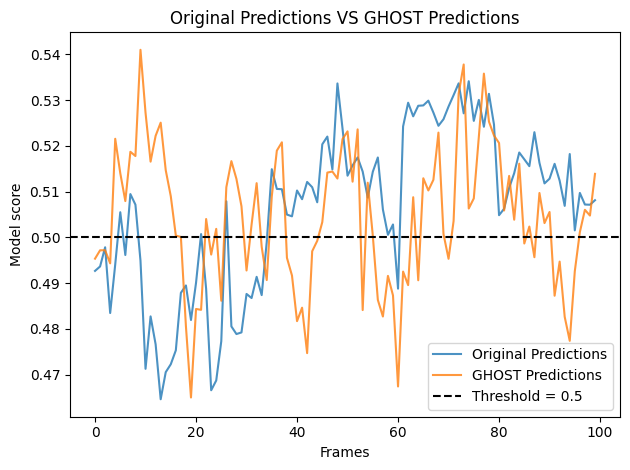

In [ ]:
# ------------------------------------------------------ #
# plot of the original predictions and ghost predictions #
# ------------------------------------------------------ #


# Sanitize real_imgs_model_outputs by replacing NaN or extreme values
# sanitized_outputs = torch.tensor(real_imgs_model_outputs).nan_to_num(nan=0.0, posinf=1.0, neginf=0.0).numpy()
# plt.plot(expit(sanitized_outputs), label='Original Predictions', alpha=0.8)
plt.plot(original_all_probs, label='Original Predictions', alpha=0.8)
plt.plot(fake_all_probs, label='GHOST Predictions', alpha=0.8)
plt.axhline(0.5, color='k', linestyle='--', label='Threshold = 0.5')  # Add threshold line
# add a text over the threshold line saying "Fake"
plt.title('Original Predictions VS GHOST Predictions')
plt.xlabel('Frames')
plt.ylabel('Model score')
# plt.xlabel('Frames')
# plt.ylabel('Model score')
plt.legend()
plt.tight_layout()
# plt.savefig('hand_occ_ORIGINAL_AND_FAKE_model_outputs_plot.png')  # Save the plot to a file
# plt.show()  # Show the plot
print("done")

In [33]:
# print the avg value of real and fake probs
print("Averagae score for REAL video: {:.4f}".format(original_all_probs.mean()))
print("Averagae score for FAKE video: {:.4f}".format(fake_all_probs.mean()))

Averagae score for REAL video: 0.5062
Averagae score for FAKE video: 0.5044


In [ ]:
# ---------------------------------------------------------------------------------------------------------------------------------- #

In [ ]:
#@title ICPR2020_repo example

model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

# Do something similar to what is done in the icpr2020 repo -> https://github.com/polimi-ispl/icpr2020dfdc/blob/master/notebook/Video%20prediction.ipynb

# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()


fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);



"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

In [ ]:
#@title Focal Loss Definition
import torch
import torch.nn as nn
import torch.nn.functional as F
# ----------------------------------------- #
# Focal loss definition
# taken from: https://github.com/facebookresearch/fvcore/blob/main/fvcore/nn/focal_loss.py
# default values: alpha = 0.25, gamma = 2 ->  https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
# ------------------------------------------------------- #
# converted as a class to define it as criterion
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = -1, gamma: float = 2, reduction: str = "mean"): # changed default reduction to mean instead of none
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        inputs = inputs.float()
        targets = targets.float()
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        # if self.reduction == "none":
            # pass
            # loss = loss.mean() # Reduce the loss to a scalar before passing it to backward
            # to reduce loss to a scalar in case of batch of images -> loss.mean() or loss.sum()
            # -> change deafualt reduction to mean
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [ ]:
#@title Perform Model Inference
import os
from torchvision.io import read_image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Create a custom Dataset to load images
class FaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB') # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

# Define the paths to the preprocessed real and fake faces
real_faces_dir_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/{vid_demo}/real/{dataset}/{frames_type}/'
fake_faces_dir_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/{vid_demo}/fake/{dataset}/{frames_type}/'

real_faces_dir_no_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/real/{dataset}/no_occ/'
fake_faces_dir_no_occ = f'/content/drive/MyDrive/Colab Notebooks/FOWS_demo/preprocessed_faces/fake/{dataset}/no_occ/'


data_transforms = transforms.Compose([
            transforms.Resize((256,256)),
            # BICUBIC is used for EfficientNetB4 -> check the documentation
            # BICUBIC vs BILINEAR -> https://discuss.pytorch.org/t/what-is-the-difference-between-bilinear-and-bicubic-interpolation/20920
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Create datasets and dataloaders
real_dataset_occ = FaceDataset(real_faces_dir_occ, transform=data_transforms)
fake_dataset_occ = FaceDataset(fake_faces_dir_occ, transform=data_transforms)

real_dataset_no_occ = FaceDataset(real_faces_dir_no_occ, transform=data_transforms)
fake_dataset_no_occ = FaceDataset(fake_faces_dir_no_occ, transform=data_transforms)


# Use DataLoader for efficient batch processing
real_dataloader_occ = DataLoader(real_dataset_occ, batch_size=32, shuffle=False)
fake_dataloader_occ = DataLoader(fake_dataset_occ, batch_size=32, shuffle=False)

real_dataloader_no_occ = DataLoader(real_dataset_no_occ, batch_size=32, shuffle=False)
fake_dataloader_no_occ = DataLoader(fake_dataset_no_occ, batch_size=32, shuffle=False)


# Perform inference
model.eval() # Set model to evaluation mode
real_predictions_occ = []
fake_predictions_occ = []
real_predictions_no_occ = []
fake_predictions_no_occ = []


with torch.no_grad(): # Disable gradient calculation
    print("Performing inference on real (occluded) faces...")
    for images, filenames in real_dataloader_occ:
        images = images.to(device)
        outputs = model(images)
        # Apply sigmoid to convert logits to probabilities (assuming binary classification)
        predictions = torch.sigmoid(outputs).squeeze().cpu().numpy()
        real_predictions_occ.extend(zip(filenames, predictions))

    print("Performing inference on fake (occluded) faces...")
    for images, filenames in fake_dataloader_occ:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs).squeeze().cpu().numpy()
        fake_predictions_occ.extend(zip(filenames, predictions))

    print("Performing inference on real (non-occluded) faces...")
    for images, filenames in real_dataloader_no_occ:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs).squeeze().cpu().numpy()
        real_predictions_no_occ.extend(zip(filenames, predictions))

    print("Performing inference on fake (non-occluded) faces...")
    for images, filenames in fake_dataloader_no_occ:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs).squeeze().cpu().numpy()
        fake_predictions_no_occ.extend(zip(filenames, predictions))


print("Inference complete.")